# Turing Target Practice

## Model

In [47]:
] activate "."

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [48]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

In [49]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [50]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [51]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm  ~ Uniform(0.01, 0.6)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [52]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [55]:
target = TuringTarget(stat_model; compute_MAP=true);

In [56]:
samples_mchmc = Sample(MCHMC(varE_wanted=1.0), target, 100000;
                       file_name="Turing_sequential_samples.txt",
                       dialog=true);

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Found sigma: [0.45043479852955454, 0.06088870443746964] ✅


eps: 0.5 --> VarE: 0.6147345809026872
eps: 0.7350022184587489 --> VarE: 1.1421327080463384
eps: 0.6420541869273673 --> VarE: 0.695922375938289
eps: 0.8454030667343679 --> VarE: 1.5670055648927272
eps: 0.5189394985761924 --> VarE: 0.7750807909147663
eps: 0.6238659844138806 --> VarE: 0.8327667364537381
eps: 0.7106478177082411 --> VarE: 1.0274462619801814
samples: 100--> ESS: 0.10268228752513142


[ Info: Found eps: 0.7106478177082411 ✅
[ Info: Found L: 2.7683365255543633 ✅


In [57]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

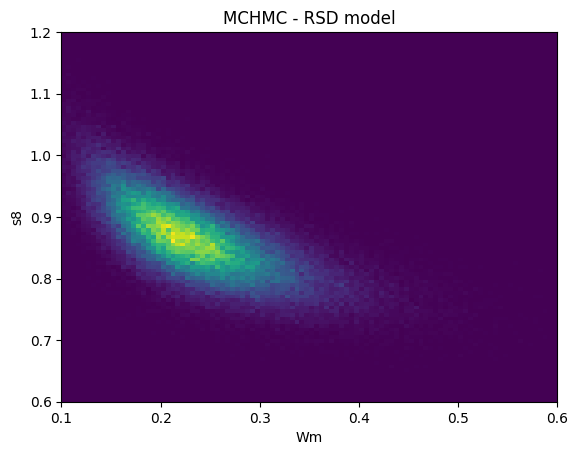

In [58]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model");

In [11]:
samples_ensemble_mchmc = Sample(MCHMC(100; varE_wanted=0.05), target, 1000, 100;
   monitor_energy=true, 
   dialog=true);

[ Info: Burn-in started ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
┌ Warning: L-tuning not Implemented
└ @ MicroCanonicalHMC ~/PhD/MicroCanonicalHMC.jl/src/ensemble/tuning.jl:41
[ Info: Found L: 1.4142135623730951 ✅


eps: 0.5 --> VarE: 2.73616720377689
eps: 0.053433660543926544 --> VarE: 5.654316749942273
eps: 0.0003967309796574555 --> VarE: 0.000833704655444937
eps: 0.0006232344422113107 --> VarE: 0.0025048858995881424
eps: 0.0009563469567440001 --> VarE: 0.002832205121179224
eps: 0.0014367908594431706 --> VarE: 0.003648822864477135
eps: 0.0021148221988587794 --> VarE: 0.0035336459814549605
eps: 0.0030549464482128477 --> VarE: 0.002559112000703923
eps: 0.004337519896516337 --> VarE: 0.014649493822849748
eps: 0.00600530296270079 --> VarE: 0.026708870553358383
eps: 0.00812078361678659 --> VarE: 0.07650085222992399
eps: 0.010499124487376927 --> VarE: 0.2058113562978318
eps: 0.012441329489320318 --> VarE: 0.43071802931469466
eps: 0.012923491546935431 --> VarE: 0.47389005943254603


[ Info: VarE condition met during eps tuning at step: 14
[ Info: Found eps: 0.012923491546935431 ✅


Initial Virial loss: 7506.356197554059
Initial sigma: [1.6840954437362896, 0.3011816025230459]
Virial loss: 84.36128020271319 --> Relative improvement: 0.026292361140158427
Sigma --> [1.6788073792826976, 0.2990127172625004]
Virial loss: 82.09133466395129 --> Relative improvement: 0.02690743352053704
Sigma --> [1.676027847214436, 0.29739633434266327]
Virial loss: 79.85924933514633 --> Relative improvement: 0.02719026725466467
Sigma --> [1.6737705121431585, 0.2959346169108133]
Virial loss: 77.66945239141641 --> Relative improvement: 0.027420705327944717
Sigma --> [1.6716843544448903, 0.29454412229007]
Virial loss: 75.52293325554957 --> Relative improvement: 0.02763659417925879
Sigma --> [1.6696680634016527, 0.2931957346520613]
Virial loss: 73.41982661502757 --> Relative improvement: 0.027847258440103828
Sigma --> [1.6676843521720939, 0.29187649621696793]
Virial loss: 71.35995046401135 --> Relative improvement: 0.028056129331618607
Sigma --> [1.6657172120962644, 0.2905797131098479]
Virial

Virial loss: 8.767123393169507 --> Relative improvement: 0.038372916674228486
Sigma --> [1.5377659152909027, 0.22570130474747743]
Virial loss: 8.421700485550078 --> Relative improvement: 0.039399799926227774
Sigma --> [1.5358411420595315, 0.2249554084568896]
Virial loss: 8.08049588635125 --> Relative improvement: 0.040514929233622876
Sigma --> [1.5339196358336453, 0.22421587441619573]
Virial loss: 7.743585662086307 --> Relative improvement: 0.04169425107115232
Sigma --> [1.5320018463890195, 0.22348263938096183]
Virial loss: 7.4112663179594245 --> Relative improvement: 0.04291543460983005
Sigma --> [1.5300882332400518, 0.22275563062686968]
Virial loss: 7.084034639323317 --> Relative improvement: 0.04415327483822029
Sigma --> [1.5281792784273154, 0.22203476958538615]
Virial loss: 6.762687295829115 --> Relative improvement: 0.045362192571788196
Sigma --> [1.5262754979465845, 0.2213199771214613]
Virial loss: 6.448549357920331 --> Relative improvement: 0.04645164328425011
Sigma --> [1.52437

[ Info: Virial loss condition met during burn-in at step: 95
[ Info: Found sigma: [1.4986572274993262, 0.211304120303579] ✅


eps: 0.012923491546935431 --> VarE: 0.0001866373652387482
eps: 0.01358355769153879 --> VarE: 0.00022925843958718426
eps: 0.014276728151435512 --> VarE: 0.0002854042860053739
eps: 0.015004428717001599 --> VarE: 0.0003575498507506829
eps: 0.015768083343940944 --> VarE: 0.00044867729197286177
eps: 0.016569094420295857 --> VarE: 0.0005625071123629268
eps: 0.01740881472036923 --> VarE: 0.0007037054399452037
eps: 0.018288509484767075 --> VarE: 0.0008780554201109373
eps: 0.01920930717367765 --> VarE: 0.0010926612235448146
eps: 0.020172136056001534 --> VarE: 0.0013562109569271233
eps: 0.021177642751784086 --> VarE: 0.0016789285719003538
eps: 0.02222609634312413 --> VarE: 0.0020710682641514053
eps: 0.02331731088592528 --> VarE: 0.002538590863261646
eps: 0.024450665890378632 --> VarE: 0.0030780192800219566
eps: 0.025625281712336825 --> VarE: 0.0036794829681815484
eps: 0.026840178110257896 --> VarE: 0.0043412567784558735
eps: 0.028094074755282347 --> VarE: 0.00508095600320102
eps: 0.0293848059196

[ Info: VarE condition met during eps tuning at step: 49
[ Info: Found eps: 0.05766275909470686 ✅


In [12]:
Wms_ensemble_mchmc = [sample[1] for sample in samples_ensemble_mchmc]
s8s_ensemble_mchmc = [sample[2] for sample in samples_ensemble_mchmc];

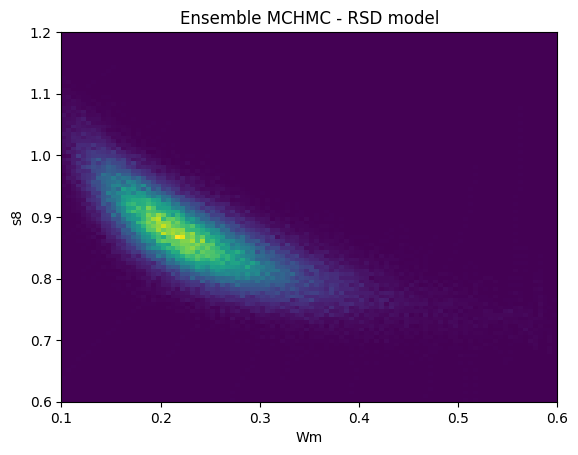

In [13]:
plt.hist2d(Wms_ensemble_mchmc, s8s_ensemble_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("Ensemble MCHMC - RSD model");

##  AbstractMCMC

In [14]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), 10000;
    monitor_energy=true, 
    dialog=true)

eps: 0.5 --> VarE: 0.5235979235300555
eps: 

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Found sigma: [0.45043479851558293, 0.06088870443655183] ✅


2.188584298838118 --> VarE: 23.271161012292428
eps: 3.570717245342175e-9 --> VarE: 1.4902825469151832e-20
eps: 2.18115865286576e-8 --> VarE: 5.560241387938062e-19
eps: 1.2198002155693984e-7 --> VarE: 1.7381669225034457e-17
eps: 6.272334373706335e-7 --> VarE: 4.587905385585107e-16
eps: 2.977741320262249e-6 --> VarE: 1.0403694148289157e-14
eps: 1.310247977734684e-5 --> VarE: 2.6060302722399306e-13
eps: 5.3633704604963107e-5 --> VarE: 2.314030382026661e-11
eps: 0.0002049606029149417 --> VarE: 4.460634968280011e-9
eps: 0.0007336808172577593 --> VarE: 6.569613216028629e-7
eps: 0.0024679299495257347 --> VarE: 1.3048347668228207e-5
eps: 0.007824593722735338 --> VarE: 0.00024844788310660244
eps: 0.02344737939478738 --> VarE: 0.002708071495964275
eps: 0.06651560301830928 --> VarE: 0.029757135347813383
eps: 0.17694345238526546 --> VarE: 0.20205491743849258
eps: 0.4136910024043152 --> VarE: 0.41337917056586326
eps: 0.8439000115785296 --> VarE: 1.576555340123951
eps: 1.0113290019321903 --> VarE: 3

[ Info: Found eps: 0.9075895245252216 ✅
[ Info: Found L: 0.7353787045265463 ✅
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 2.32 seconds
Compute duration  = 2.32 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2339    0.0629     0.0006    0.0018    987.9946    1.0002    ⋯
          σ8    0.8679    0.0603     0.0006    0.0017   1029.4417    1.0002    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1286    0.1886    0.2279    0.2721    0.3754
          σ8    0.7587    0.8259    0.8654    0.9062    0.9928


In [15]:
new_samples = sample(stat_model, MCHMC(varE_wanted=2.0), 10000; 
                     monitor_energy=true, 
                     progress=true, resume_from=samples)

[ Info: Starting from previous run
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 0.71 seconds
Compute duration  = 0.71 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2372    0.0640     0.0006    0.0020    936.3047    1.0002    ⋯
          σ8    0.8649    0.0597     0.0006    0.0017   1027.6432    1.0001    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1321    0.1911    0.2304    0.2761    0.3788
          σ8    0.7532    0.8241    0.8626    0.9032    0.9900


## Ensemble AbstractMCMC

In [16]:
samples = sample(stat_model, MCHMC(100), 1000, 100)

[ Info: Burn-in started ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
┌ Warning: L-tuning not Implemented
└ @ MicroCanonicalHMC ~/PhD/MicroCanonicalHMC.jl/src/ensemble/tuning.jl:41
[ Info: Found L: 1.4142135623730951 ✅
[ Info: VarE condition met during eps tuning at step: 7
[ Info: Found eps: 0.008771615483189136 ✅
[ Info: Virial loss condition met during burn-in at step: 29
[ Info: Found sigma: [1.6210966264327005, 0.27798429384397405] ✅
┌ Warning: Maximum number of steps reached during eps tuning
└ @ MicroCanonicalHMC ~/PhD/MicroCanonicalHMC.jl/src/ensemble/tuning.jl:214
[ Info: Found eps: 0.015346849535888529 ✅
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:03


Chains MCMC chain (100000×4×1 Array{Float64, 3}):

Iterations        = 1:1:100000
Number of chains  = 1
Samples per chain = 100000
Wall duration     = 3.38 seconds
Compute duration  = 3.38 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2936    0.1603     0.0005    0.0086   226.5623    1.0010     ⋯
          σ8    0.7719    0.2556     0.0008    0.0136   229.4126    1.0376     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.0467    0.1696    0.2974    0.4244    0.5792
          σ8    0.2450    0.6034    0.7746    0.9356    1.2669


In [17]:
new_samples = sample(stat_model, MCHMC(100), 1000, 100; 
                     resume_from=samples)

[ Info: Starting from previous run
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:03


Chains MCMC chain (100000×4×1 Array{Float64, 3}):

Iterations        = 1:1:100000
Number of chains  = 1
Samples per chain = 100000
Wall duration     = 3.52 seconds
Compute duration  = 3.52 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2422    0.0770     0.0002    0.0041   231.8493    1.0041     ⋯
          σ8    0.8615    0.0666     0.0002    0.0036   226.0563    1.0295     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1470    0.1999    0.2258    0.2690    0.4739
          σ8    0.7134    0.8121    0.8676    0.9066    0.9891


## Parallelization

In [18]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true)

eps: 0.5 --> VarE: 0.5545175289591648
eps: 0.5 --> VarE: 1.1285793383815554
eps: 0.5 --> VarE: 0.514238555105526
eps: 0.5 --> VarE: 0.7740801161641031
eps: 

[ Info: Tuning sigma ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Tuning L ⏳
[ Info: Tuning L ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Found sigma: [0.4504347985295135, 0.060888704437467106] ✅
[ Info: Found sigma: [0.4504347985295135, 0.060888704437467106] ✅
[ Info: Found sigma: [0.4504347985295135, 0.060888704437467106] ✅
[ Info: Found sigma: [0.4504347985295135, 0.060888704437467106] ✅


2.121949603711918 --> VarE: 21.65821378771636
eps: 1.195152128014069 --> VarE: 5.8348743183167215
eps: 2.2091642229355584 --> VarE: 32.35056924297993
eps: 1.7036494804330604 --> VarE: 17.175183205250097
eps: 0.031130357522075727 --> VarE: 0.05207600655854001
eps: 1.6056756703904256e-8 --> VarE: 8.1060895702143e-19
eps: 9.168627179018129e-7 --> VarE: 1.9364456019278547e-14
eps: 6.397235596382366e-13 --> VarE: 4.2993737017695646e-27
eps: 0.18140606761774072 --> VarE: 0.4201800084474737
eps: 9.808206983447365e-8 --> VarE: 3.026348177302898e-17
eps: 5.600620024590827e-6 --> VarE: 2.8451008072245483e-12
eps: 3.9077263240800575e-12 --> VarE: 1.3506338659229691e-25
eps: 0.706626087497483 --> VarE: 1.970675636304126
eps: 5.485182371781695e-7 --> VarE: 9.502107266585936e-16
samples: 100--> ESS: 0.09306316597448244
samples: 203--> ESS: 0.10733175964287077
eps: 3.1321139818626024e-5 --> VarE: 2.9869267176879417e-9
eps: 2.1853730842716608e-11 --> VarE: 4.17621973839868e-24
eps: 

[ Info: Found eps: 0.706626087497483 ✅
[ Info: Found L: 2.6334277565137034 ✅


2.820535485847105e-6 --> VarE: 2.6142871636754894e-14
eps: 0.000161056424584982 --> VarE: 1.6125361770626805e-6
eps: 1.1237406372691312e-10 --> VarE: 1.1029724604922426e-22
eps: 1.3390269971385209e-5 --> VarE: 9.293419120346891e-13
eps: 0.0007646017248503756 --> VarE: 1.8180709280293145e-5
eps: 5.334870128865353e-10 --> VarE: 2.4852964446501553e-21
eps: 5.8919067388203656e-5 --> VarE: 9.678421727298899e-11
eps: 2.3474177391632675e-9 --> VarE: 4.811457239698922e-20
eps: 0.003364309599181438 --> VarE: 0.00026796462253885124
eps: 0.00024117937286553676 --> VarE: 4.324454467357423e-9
eps: 9.608922260992801e-9 --> VarE: 8.061002038075344e-19
eps: 0.013768868237131781 --> VarE: 0.003487572295009331
eps: 0.0009216642761251222 --> VarE: 4.881841867282291e-7
eps: 0.052494710982684566 --> VarE: 0.025465874097646644
eps: 3.672038906341351e-8 --> VarE: 1.176668395846691e-17
eps: 0.0032992057066639218 --> VarE: 1.2122464110215545e-5
eps: 0.18488443724401737 --> VarE: 0.18434444235964023
eps: 1.3144

[ Info: Found eps: 0.9352945447914329 ✅
[ Info: Found L: 1.543245035857072 ✅


eps: 0.8549891454249596 --> VarE: 1.6809137531241245
eps: 0.001079267027495434 --> VarE: 1.2962892709431487e-5
eps: 0.0023390834535222094 --> VarE: 5.420195463500389e-5
eps: 0.9672843588325476 --> VarE: 2.440854898265587
eps: 0.0048817224012560586 --> VarE: 0.00023930994152961506
eps: 0.8224692217068511 --> VarE: 1.4824944864864977
eps: 0.009828534742765644 --> VarE: 0.0007353762033289508
eps: 0.9857529605231478 --> VarE: 2.4675695427786333
eps: 0.019121000721266667 --> VarE: 0.00379781413386268
eps: 0.8436733517287399 --> VarE: 1.52342494635326
eps: 0.03597622330097833 --> VarE: 0.011395469661377892
eps: 0.9810923374905405 --> VarE: 2.9278359187421725
eps: 0.06548456268811624 --> VarE: 0.024415273221354308
eps: 0.7418950363296406 --> VarE: 1.7101622442083189
eps: 0.11533361534082016 --> VarE: 0.05335207393088496
eps: 0.8061321444786711 --> VarE: 1.3884946980000958
eps: 0.9523211462829919 --> VarE: 2.2778809351328557
eps: 0.19604659905162658 --> VarE: 0.189916643208753
eps: 0.313437150

[ Info: Found eps: 0.8861306412762562 ✅
[ Info: Found L: 2.6199187132367916 ✅


eps: 0.6590921423674317 --> VarE: 0.8121257482238666
eps: 0.8591245608326009 --> VarE: 1.316648760357345
eps: 0.9932216327810521 --> VarE: 2.545335842360297
eps: 0.8896716184239079 --> VarE: 1.5885475759651266


[ Info: Found eps: 0.9628251497297725 ✅
[ Info: Found L: 1.2058867913849656 ✅


eps: 0.9628251497297725 --> VarE: 2.0245047020546183
samples: 100--> ESS: 0.3193749717165288


chain 3:   4%|█▋                                        |  ETA: 0:00:02
chain 4:   4%|█▋                                        |  ETA: 0:00:02
chain 1:   4%|█▋                                        |  ETA: 0:00:02









chain 4:   9%|███▊                                      |  ETA: 0:00:02
chain 1:  10%|████                                      |  ETA: 0:00:02
chain 3:  10%|████▎                                     |  ETA: 0:00:02
chain 2:  10%|████                                      |  ETA: 0:00:02
chain 4:  14%|██████▏                                   |  ETA: 0:00:02
chain 1:  14%|██████▏                                   |  ETA: 0:00:02
chain 2:  14%|██████▏                                   |  ETA: 0:00:02
chain 3:  16%|██████▊                                   |  ETA: 0:00:02
chain 4:  20%|████████▎                                 |  ETA: 0:00:02
chain 1:  20%|████████▎                                 |  ETA: 0:00:02
chain 3:  21%|████████▉                                

4-element Vector{Chains}:
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})

In [19]:
new_samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true, 
    resume_from=samples)

[ Info: Starting from previous run
chain 1:   4%|█▉                                        |  ETA: 0:00:02
chain 3:   4%|█▋                                        |  ETA: 0:00:03
chain 4:   5%|██▏                                       |  ETA: 0:00:02









chain 1:  10%|████▎                                     |  ETA: 0:00:02


chain 3:  10%|████                                      |  ETA: 0:00:02
chain 2:  10%|████▍                                     |  ETA: 0:00:02
chain 4:  11%|████▋                                     |  ETA: 0:00:02

chain 1:  16%|██████▊                                   |  ETA: 0:00:02
chain 3:  15%|██████▎                                   |  ETA: 0:00:02
chain 2:  16%|██████▊                                   |  ETA: 0:00:02
chain 4:  17%|███████▏                                  |  ETA: 0:00:02
chain 1:  22%|█████████                                 |  ETA: 0:00:02
chain 3:  20%|████████▍                                 |  ETA: 0:00:02
chain 4:  23%|███

4-element Vector{Chains}:
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})

## NUTS

In [20]:
samples_hmc = sample(stat_model, NUTS(10, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06


Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 11:1:10010
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 10.62 seconds
Compute duration  = 10.62 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2370    0.0698     0.0007    0.0018   1521.2918    1.0000    ⋯
          σ8    0.8672    0.0634     0.0006    0.0014   2094.1362    1.0002    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

     

In [21]:
samples_hmc.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 11:1:10010
    :var, [:Ωm, :σ8, :lp, :n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size]
    :chain, 1:1
And data, a 10000×14×1 Array{Float64, 3}:
[:, :, 1] =
 0.142682  0.975125  14.8886  37.0  1.0  …  5.0  0.0  0.0408394  0.0408394
 0.213649  0.918899  15.6112  31.0  1.0     4.0  0.0  0.0408394  0.0408394
 0.243588  0.784014  14.5983  23.0  1.0     4.0  0.0  0.0408394  0.0408394
 0.242184  0.805322  15.4589   3.0  1.0     2.0  0.0  0.0408394  0.0408394
 0.221099  0.815317  15.3338  15.0  1.0     3.0  0.0  0.0408394  0.0408394
 0.224389  0.899871  15.9003   3.0  1.0  …  2.0  0.0  0.0408394  0.0408394
 0.219803  0.875915  16.2979   3.0  1.0     2.0  0.0  0.0408394  0.0408394
 0.200948  0.90639   16.0918  15.0  1.0     3.0  0.0  0.0408394  0.0408394
 0.202655  0.930752  15.5048   3.0  1.0 

In [22]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

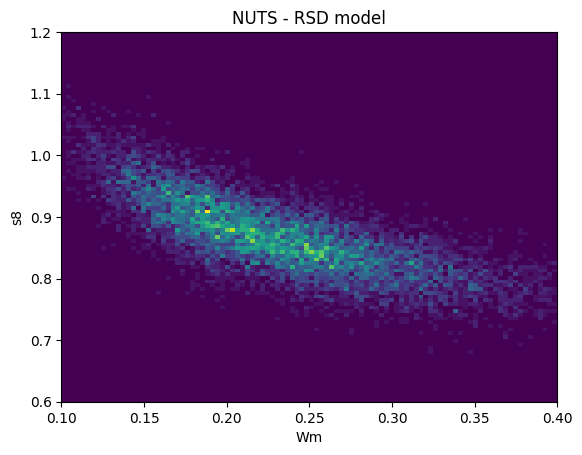

In [23]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("NUTS - RSD model");